# Laboratory #4_2 : Image Classification using Bag of Visual Words

At the end of this laboratory, you would get familiarized with

*   Creating Bag of Visual Words
    *   Feature Extraction
    *   Codebook construction
    *   Classification
*   Using pre-trained deep networks for feature extraction

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [22]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)
import os
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from skimage.color import rgb2gray
from skimage.io import imread
from skimage import feature
from scipy.cluster.vq import vq
import glob
from matplotlib import pyplot as plt
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split

## Loading dataset

We will use 3 categories from Caltech 101 objects dataset for this experiment. Upload the dataset to the drive and mount it.

In [23]:
# modify the dataset variable with the path from your drive
dataset_path = '/Users/Eric/Documents/Uni/Msc/Courses/Sem1/CV/LAB/p4_2_image_classification_using_BoVW/101_ObjectCategories'

In [24]:
categories = ['butterfly', 'kangaroo', 'dalmatian']
ncl = len(categories) * 10

*   Create a list of file and the corresponding labels

In [25]:
#solution
def get_fn_label(listoffiles):
    fn_label = []
    for category in listoffiles:
        #list of the corresponing files 
        all_files = glob.glob(dataset_path + '/' + category +'/*.jpg')
        _ = [fn_label.append((x,category)) for x in all_files]
    return fn_label

In [26]:
data = get_fn_label(categories)
print('Total number of images:', len(data))

Total number of images: 244


*   Create a train / test split where the test is 10% of the total data

In [27]:
# solution
df = pd.DataFrame(data)
df.columns = ['fn','label']
X = df.drop('label',axis=1)
y = df.drop('fn',axis=1)
#splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
#check
print('Train set:', len(X_train))
print('Test set:', len(X_test))

Train set: 219
Test set: 25


*   How do you select the train/test split?

**Solution**

By using the "test_size" parameter of the train_test_split function from sklearn.model_selection, we chose the test_size and the training is complementary to the test_size. 

## Feature Extraction using ORB

The first step is to extract descriptors for each image in our dataset. We will use ORB to extract descriptors.

*   Create ORB detector with 256 keypoints.


In [28]:
# solution
descriptor_extractor = feature.ORB(n_keypoints=256)

*   Extract ORB descriptors from all the images in the train set.


In [29]:
# solution
def all_to_gray(image): 
  try: 
    image_gray = rgb2gray(cv2.cvtColor(image, cv2.COLOR_RGBA2RGB))
  except Exception as e:
    image_gray = rgb2gray(image)
  return image_gray
#####################################################

def get_ORB(image1,n_keypoints_ = 256):
  IMAGE1_GRAY = all_to_gray(image1)
  #instantiate the ORB
  DescExt = feature.ORB(n_keypoints = n_keypoints_)
  #Detect and Extract features for image 1
  DescExt.detect_and_extract(IMAGE1_GRAY)
  kpts = DescExt.keypoints
  descr = DescExt.descriptors
  return descr

# Much faster ORB feature
def cv2_ORB(image, keypoints=256):
    ORB = cv2.ORB_create(nfeatures=keypoints)
    img = cv2.imread(image)
    _, desc = ORB.detectAndCompute(img, None)
    return desc

# Running
# MUCH SLOWER
vals = X_train.values.reshape(-1,)
read_imgs = list(map(plt.imread, vals))
descr = [get_ORB(x) for x in read_imgs]

# MUCH FAST
vals_cv2 = X_train.values.reshape(-1,)
descr_cv2 = list(map(cv2_ORB, vals_cv2))
# TEST
vals_test_cv2 = X_test.values.reshape(-1,)
descr_test_cv2 = list(map(cv2_ORB, vals_test_cv2))

*   What is the size of the feature descriptors? What does each dimension represent in the feature descriptors?

In [30]:
# solution
print(f"Single descriptor dimension {descr_cv2[0].ndim}")
print(f"Single descriptor shape {descr_cv2[0].shape}")
print(f"Image shape {read_imgs[0].shape}")

Single descriptor dimension 2
Single descriptor shape (243, 32)
Image shape (261, 300, 3)


**Solution**

OpenCV's ORB feature extractor uses BRIEF-32, which means that it stores 32 bytes for each giving a length of 256 bit (32*8). In each of the bytes it contains 8 pixel intensity comparisson, as it is explained in the original paper. So each dimensions corresponds to the corresponding pixel intensity comparisson. So what does this tell us? It tells us that ORB, retrieved an array of shape (243, 32), corresponding to its descriptors. These descriptors are what we would use to construct a Codebook, since it tells us "which features" are the ones "decided by ORB" are the most important. We'd be able to graph these as in previous labs, alongside their keypoints and see which pixels were selected.

## Codebook Construction

Codewords are nothing but vector representation of similar patches. This codeword produces a codebook similar to a word dictionary. We will create the codebook using K-Means algorithm

*   Create a codebook using K-Means with k=number_of_classes*10
*   Hint: Use sklearn.cluster.MiniBatchKMeans for K-Means

In [31]:
#stacking the descriptors 
def vStackDescriptors(descriptors_list):
    desc = np.array(descriptors_list[0])
    for d in descriptors_list[1:]:
        desc = np.vstack((desc, d))
    return desc

vstackdesc = vStackDescriptors(descr_cv2)
vstackdesc_test = vStackDescriptors(descr_test_cv2)

BATCH_SIZE = len(X_train) // ncl
RANDOM_STATE = 42
MAX_ITER = 5000
# solution
kmeans = MiniBatchKMeans(n_clusters=ncl,
                         random_state=RANDOM_STATE,
                         batch_size=BATCH_SIZE,
                         max_iter=MAX_ITER)

kmeans = kmeans.fit(vstackdesc)
kmeans_test = kmeans.fit(vstackdesc_test)

*   Create a histogram using the cluster centers for each image descriptor.
    *   Remember the histogram would be of size *n_images x n_clusters*.

In [32]:
###########################################
# Defining variables for the functions 
LIST_OF_DESCRIPTORS = descr_cv2
IMAGES_COUNT = len(X_train)
NUMBER_OF_CLUSTERS = ncl

LIST_OF_DESC_TEST = descr_test_cv2
IMAGES_TEST_COUNT = len(X_test)

############################################

def extract_features(KMEANS, DESCRIPTORS=LIST_OF_DESCRIPTORS, NUMBER_OF_IMAGES=IMAGES_COUNT, CLUSTERS=NUMBER_OF_CLUSTERS,RETURN_SCALED=False):
    #creating an empty array of size NUMBER_OF_CLUSTERS x NUMBER_OF_IMAGES
    IMG_FEATURES = np.array([np.zeros(CLUSTERS) for images in range(NUMBER_OF_IMAGES)])
    # we can loop through the image count 
    for img in range(NUMBER_OF_IMAGES):
        # we then loop through the descriptors for each image
        for desc in range(len(DESCRIPTORS[img])):
            #now we can extract the specific feature for each of them 
            FEATURE = DESCRIPTORS[img][desc]
            #Reshaping into the corresponding size --> (243, 32) now we have (32,) and needs to go to (1,32)
            FEATURE = FEATURE.reshape(1,32)
            #Let's predict with the k-Means
            pred_idx = KMEANS.predict(FEATURE)
            # we add a count for that specific feature --> since we need to make a histogram 
            IMG_FEATURES[img][pred_idx] +=1
    # we need to remove the mean and scale to unit variance 
    if RETURN_SCALED:
        stscale = StandardScaler().fit(IMG_FEATURES)
        IMG_FEATURES = stscale.transform(IMG_FEATURES)
        return IMG_FEATURES
    else: 
        return IMG_FEATURES

def draw_hist(IMAGE_FEATURES, CLUSTERS_NUM):
    # we need to make both (x, y) scalar 
    SCALAR_X = np.arange(CLUSTERS_NUM)
    # now for y: we sum over the axis=0 and convert it into dtype=int32 to keep a whole number & make it positive 
    SCALAR_Y = np.array(abs(np.sum(IMAGE_FEATURES, axis=0, dtype=np.int32)))
    #make a barplot
    plt.bar(SCALAR_X, SCALAR_Y)
    #labels
    plt.xlabel('INDEX'); plt.ylabel('FREQUENCY'); plt.title("Graph 1. Codebook Histogram")
    plt.xticks(SCALAR_X + 0.8, SCALAR_X)
    plt.tight_layout()
    plt.show()

# solution
IMG_FEATURES = extract_features(kmeans, LIST_OF_DESCRIPTORS,IMAGES_COUNT,NUMBER_OF_CLUSTERS,RETURN_SCALED=True)

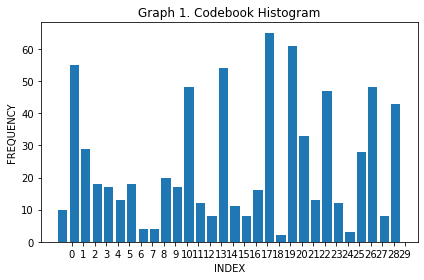

In [33]:
draw_hist(IMG_FEATURES, NUMBER_OF_CLUSTERS)


# Creating Classification Model

*   The next step is to create a classification model. We will use a C-Support Vector Classification for creating the model.



In [36]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

*   Use GridSearchCV to find the optimal value of C and Gamma.

In [60]:
#Solution
def svcParamSelection(X, y, kernel, nfolds):
    #Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    Cs2 = list(np.arange(0.01,1.0, 50))
    #gammas = [0.1, 0.11, 0.095, 0.105]
    gammas_2 = list(np.arange(0.08, 0.15, 50))
    param_grid = {'C': Cs2, 'gamma' : gammas_2}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param)
    print(features.shape)
    print(train_labels.shape)
    svm.fit(features, train_labels)
    return svm

In [61]:
svm = findSVM(IMG_FEATURES, y_train.values.ravel(),'precomputed')

0.01 0.08
(219, 219)
(219,)


# Testing the Classification Model

*   Extract descriptors using ORB for the test split
*   Use the previously trained k-means to generate the histogram
*   Use the classifier to predict the label


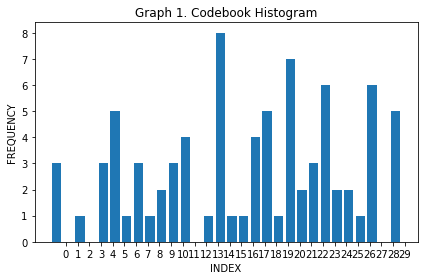

In [65]:
# The descriptors for the X_test have been extracted alongside with the train 
IMG_FEATURES_TEST = extract_features(kmeans, LIST_OF_DESC_TEST,IMAGES_TEST_COUNT,NUMBER_OF_CLUSTERS,RETURN_SCALED=True)
# drawing the histogram 
draw_hist(IMG_FEATURES_TEST, NUMBER_OF_CLUSTERS)


In [72]:
# Predicting the label 
test_features = np.dot(IMG_FEATURES_TEST, IMG_FEATURES.T) # getting (test_samples_n, train_samples_n)
y_pred = svm.predict(test_features)
#y_pred
y_pred

array(['butterfly', 'butterfly', 'kangaroo', 'kangaroo', 'kangaroo',
       'kangaroo', 'kangaroo', 'kangaroo', 'butterfly', 'kangaroo',
       'butterfly', 'dalmatian', 'butterfly', 'dalmatian', 'butterfly',
       'kangaroo', 'dalmatian', 'butterfly', 'butterfly', 'kangaroo',
       'dalmatian', 'dalmatian', 'kangaroo', 'butterfly', 'butterfly'],
      dtype=object)

*   Calculate the accuracy score for the classification model

In [74]:
score = svm.score(test_features, y_test.values.ravel())
print(f"The score for the SVM Classification Model is {score*100}%")

The score for the SVM Classification Model is 72.0%


*   Generate the confusion matrix for the classification model

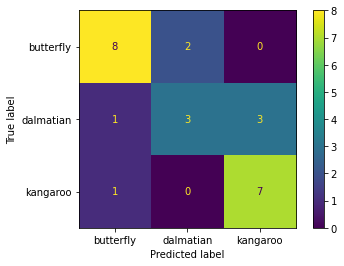

In [76]:
# solution
from sklearn.metrics import plot_confusion_matrix

cm = plot_confusion_matrix(svm,test_features, y_test.values.ravel())

*   Why do we use Clustering to create the codebook? 
*   What are the other techniques that can be used to create the codebook?

**Solution**

We use clustering in order to create the codebook because we want to group the extracted features of the images. Imagine that the features of the ORB descriptors are different shapes (triangles, circles, squares, rectangles) and now we want to group these in order to have a "count" of features for a given image and then dataset. This then allows us to compare the "count" of the train images to the ones in the testing set. This will then allow us to compare these two and see how similar they are, because having an overlapping "codebook" or "count" we can calculate the similarity of the images. 


**Other Methods**:
We can use different clustering methods since K-means is able to cluster them densely or sparsely, depending on how it works. And depedning on the origin of the images, they might not be i.i.d. which can mean that the clustering can be sensitive to values that are considered outliers and pushes them to a specific cluster. Jurie et al has shown a "scalable acceptance-radius based clusterer", this still uses clustering but it is more efficient. 

Another method is using CNN's, here we can use the last layers of the model which is a FE layer, this allows us to be able to use those features to make our own codebook! Essentially what we would need to do is either train a new model from scratch or we can use a pre-trained model (ImageNet, GoogleNet, LeNet, ResNet), and then we freeze the last layers (set the trainable parameter to FALSE) and then we can use a SVM on those features to classify the images! Or we can even further use these features in another NN which is specialized to our task. 

On the other hand, I was thinking that we could also use a shallow deep neural network, the architecture would be a CNN and we can use Transformers, algonside a 1D or 2D Convolution in order to extract features. I mention this since Transformers are SoTA and these classes are freely avaiable from HuggingFace algonside their pre-trained models. 

https://jurie.users.greyc.fr/papers/05-jurie-triggs-iccv.pdf

*   Will adding more keypoints increase the performanc of the algorithm?

**Solution**

*(Double-click or enter to edit)*

...

# Extracting features from Deep Network

It is quite possible to extract features (similar to SIFT or ORB) from different layers of deep network.

*   Load ResNet50 model with imagenet weights and check the summary of the model
*   Create a model to extract features from the 'avg_pool' layer.
*   Extract features from the layer for all the train images.

In [ ]:
# solution



*   What is the size of the feature descriptors?

In [ ]:
# solution



*   Create codebook using the extracted features

In [ ]:
# solution



*   Train SVM classifier using the codebook

In [ ]:
# solution



*   Evaluate the test set using the above method

In [ ]:
# solution



*   Calculate the accuracy score and confusion matrix for the classification model

In [ ]:
# solution



*   Compare the performance of both the BoVW models. Which model works better and why?

**Solution**

*(Double-click or enter to edit)*

...

*   Can the performance of pre-trained model increased further? If so, how?

**Solution**

*(Double-click or enter to edit)*

...

*   What happens if the test image does not belong to any of the trained classes?

**Solution**

*(Double-click or enter to edit)*

...

*   Combine the features extracted using ORB and Deep Neural Network.
*   Create a codebook with the combined features
*   Train a SVM classifier using the generated codebook and evaluate the performance using accuracy and confusion matrix.

In [ ]:
# solution



*   Do the combined features increase the performance of the classifier?

**Solution**

*(Double-click or enter to edit)*

...

## t-distributed Stochastic Neighbor Embedding (Optional).

In order to visualize the features of a higher dimension data, t-SNE is used. t-SNE converts the affinities of the data points to probabilities. It recreates the probability distribution in a low-dimensional space. It is very helpful in visualizing features of different layers in a neural network.

You can find more information about t-SNE [here](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne)

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)

np.set_printoptions(suppress=True)

low_embedding = model.fit_transform(dictionary) 

plt.figure(figsize=(20,10))
plt.scatter(low_embedding[:, 0], low_embedding[:, 1], c=y_train)
plt.title("TSNE visualization")
plt.show()

*   What do you infer from the t-SNE plot?

**Solution**

*(Double-click or enter to edit)*

...


---

## **End of P4_2: Image Classification using Bag of Visual Words**
Deadline for P4_2 submission in CampusVirtual is: **Monday, the 6th of December, 2021**